In [1]:
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
from matplotlib import cm
from keras.datasets.cifar10 import load_data

import random
import numpy as np

In [2]:
def DataLoad(subset=None):
  (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
  
  if subset is not None:
    train_length = int(len(x_train) * subset)
    x_train = x_train[:train_length]
    y_train = y_train[:train_length]
    
    test_length = int(len(x_test) * subset)
    x_test = x_test[:test_length]
    y_test = y_test[:test_length]
  
  val_split = 0.2
  val_length = int(len(x_train) * val_split)
  x_val = x_train[:val_length]
  y_val = y_train[:val_length]
  
  x_train = x_train[val_length:]
  y_train = y_train[val_length:]
  
  return x_train, y_train, x_val, y_val, x_test, y_test

x_train, y_train, x_val, y_val, x_test, y_test = DataLoad()

In [3]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((40000, 32, 32, 3),
 (40000, 1),
 (10000, 32, 32, 3),
 (10000, 1),
 (10000, 32, 32, 3),
 (10000, 1))

In [4]:
# Labels
lables = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

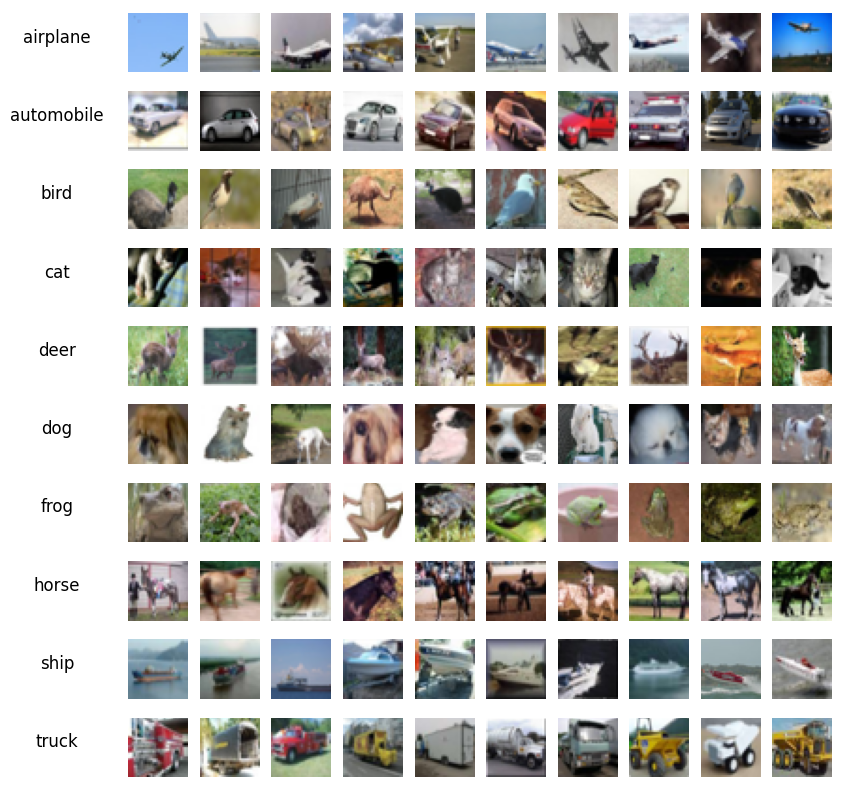

In [5]:
# Plot the 10 images from each label
fig, axes = plt.subplots(10, 11, figsize=(10, 10))

for i in range(10):
    axes[i, 0].text(0, 0.5, lables[i], fontsize=12, ha='center')
    axes[i, 0].axis('off')
    for j in range(1, 11):  # Modify the range to start from 1 instead of 0
        index = random.choice(np.where(y_train == i)[0])
        axes[i, j].imshow(x_train[index])
        axes[i, j].axis('off')

In [7]:
import numpy as np

x_train_reshaped = np.moveaxis(x_train, -1, 1)  # Move channel dimension to second position
x_train_reshaped = x_train_reshaped.reshape(x_train_reshaped.shape[0], 32, 32*3)  # Reshape to (num_samples, 32, 32*3)

x_val_reshaped = np.moveaxis(x_val, -1, 1)  # Move channel dimension to second position
x_val_reshaped = x_val_reshaped.reshape(x_val_reshaped.shape[0], 32, 32*3)  # Reshape to (num_samples, 32, 32*3)

# convert to float32
x_train_reshaped = x_train_reshaped.astype('float32')
x_val_reshaped = x_val_reshaped.astype('float32')

# Now x_train_reshaped has the shape (num_samples, 32, 96), which is compatible with LSTM input shape
x_train_reshaped.shape, x_train_reshaped[0].shape, x_val_reshaped.shape, x_val_reshaped[0].shape

((40000, 32, 96), (32, 96), (10000, 32, 96), (32, 96))

In [15]:
from keras.layers import LSTM, Dense, Flatten

class RowLSTM(tf.keras.Model):
    def __init__(self, num_classes):
        super(RowLSTM, self).__init__()
        self.lstm1 = LSTM(128, return_sequences=True)
        self.lstm2 = LSTM(256, return_sequences=True)
        self.flatten = Flatten()
        self.output_layer = Dense(num_classes, activation='softmax')
        
    def build(self, input_shape):
        super(RowLSTM, self).build(input_shape)
    
    def get_config(self):
        return self
    
    def call(self, x):
        # Reshape input to fit LSTM input shape
        x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.flatten(x)
        x = self.output_layer(x)
        return x

num_classes = 10  # CIFAR-10 has 10 classes
model_rowlstm = RowLSTM(num_classes)

# Input shape for CIFAR-10 images
input_shape = (32, 32, 3)

model_rowlstm.build(input_shape=(None, *input_shape))  # None for batch size

model_rowlstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [9]:
from keras.layers import Bidirectional, LSTM, Dense, Flatten
class BiLSTM(tf.keras.Model):
    def __init__(self, num_classes):
        super(BiLSTM, self).__init__()
        self.bilstm1 = Bidirectional(LSTM(128, return_sequences=True))
        self.bilstm2 = Bidirectional(LSTM(256, return_sequences=True))
        self.flatten = Flatten()
        self.output_layer = Dense(num_classes, activation='softmax')
        
    def build(self, input_shape):
        super(BiLSTM, self).build(input_shape)

    def call(self, x):
        x = self.bilstm1(x)
        x = self.bilstm2(x)
        x = self.flatten(x)
        x = self.output_layer(x)
        return x
    
    def get_config(self):
        return self

num_classes = 10  # CIFAR-10 has 10 classes
model_bilstm = BiLSTM(num_classes)

# Input shape for CIFAR-10 images
input_shape = (32, 32, 3)

model_bilstm.build(input_shape=(None, *input_shape))  # None for batch size

model_bilstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the rowlstm
history_rowlstm = model_rowlstm.fit(x_train_reshaped, y_train, epochs=20, validation_data=(x_val_reshaped, y_val))

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.2586 - loss: 2.0520 - val_accuracy: 0.3241 - val_loss: 1.8563
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.3540 - loss: 1.8120 - val_accuracy: 0.3680 - val_loss: 1.7352
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.3826 - loss: 1.7241 - val_accuracy: 0.4060 - val_loss: 1.6664
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.4091 - loss: 1.6488 - val_accuracy: 0.4026 - val_loss: 1.6676
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.4140 - loss: 1.6447 - val_accuracy: 0.4146 - val_loss: 1.6380
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.4225 - loss: 1.6211 - val_accuracy: 0.4224 - val_loss: 1.6060
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.4407 - loss: 1.5679 - val_accuracy: 0.4291 - val_loss: 1.5844
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.4463 - loss: 1.5456 -

In [ ]:
# Train the bilstm
history_bilstm = model_bilstm.fit(x_train_reshaped, y_train, epochs=20, validation_data=(x_val_reshaped, y_val))

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.2792 - loss: 2.0084 - val_accuracy: 0.3429 - val_loss: 1.8551
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.3558 - loss: 1.8270 - val_accuracy: 0.3597 - val_loss: 1.7897
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.3641 - loss: 1.7770 - val_accuracy: 0.3975 - val_loss: 1.6859
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.3883 - loss: 1.6985 - val_accuracy: 0.3875 - val_loss: 1.7300
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.4068 - loss: 1.6688 - val_accuracy: 0.4090 - val_loss: 1.6417
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.4190 - loss: 1.6369 - val_accuracy: 0.4189 - val_loss: 1.6263
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.4315 - loss: 1.5952 - val_accuracy: 0.4264 - val_loss: 1.6030
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.4401 -

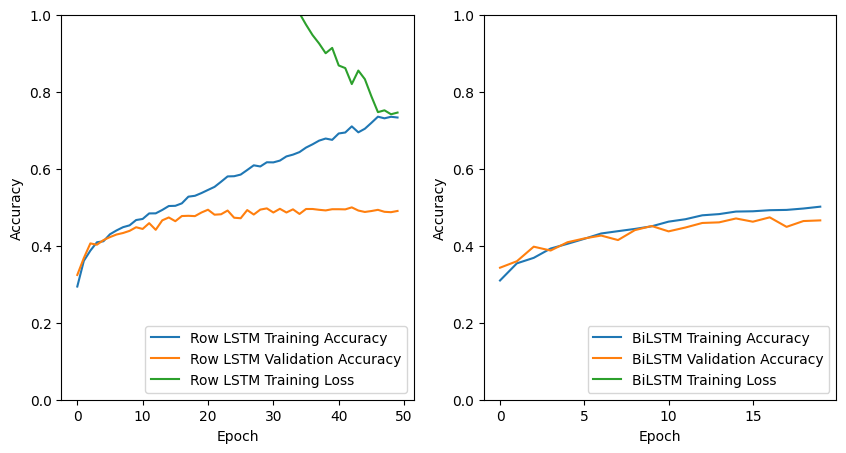

In [ ]:
# Plot the training history 
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_rowlstm.history['accuracy'], label='Row LSTM Training Accuracy')
plt.plot(history_rowlstm.history['val_accuracy'], label='Row LSTM Validation Accuracy')
plt.plot(history_rowlstm.history['loss'], label='Row LSTM Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_bilstm.history['accuracy'], label='BiLSTM Training Accuracy')
plt.plot(history_bilstm.history['val_accuracy'], label='BiLSTM Validation Accuracy')
plt.plot(history_bilstm.history['loss'], label='BiLSTM Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.show()

In [10]:

x_test_reshaped = np.moveaxis(x_test, -1, 1)  # Move channel dimension to second position
x_test_reshaped = x_test_reshaped.reshape(x_test_reshaped.shape[0], 32, 32*3)  # Reshape to (num_samples, 32, 32*3)

# convert to float32
x_test_reshaped = x_test_reshaped.astype('float32')

x_test_reshaped.shape, x_test_reshaped[0].shape

((10000, 32, 96), (32, 96))

In [ ]:
# test model

# Save the model with accuracy
path = ''

test_loss, test_acc = model_rowlstm.evaluate(x_test_reshaped,  y_test, verbose=2)

print(f"Row LSTM: {test_acc}")

model_name = 'rowlstm'

keras.saving.save_model(model_rowlstm, path + model_name + '_' + str(int(test_acc*100)) + '.keras')


test_loss, test_acc = model_bilstm.evaluate(x_test_reshaped,  y_test, verbose=2)

print(f"Bi LSTM: {test_acc}")

model_name = 'bilstm'

keras.saving.save_model(model_bilstm, path + model_name + '_' + str(int(test_acc*100)) + '.keras')


313/313 - 1s - 3ms/step - accuracy: 0.4809 - loss: 1.8838
Row LSTM: 0.48089998960494995
313/313 - 1s - 4ms/step - accuracy: 0.4638 - loss: 1.5303
Bi LSTM: 0.46380001306533813


In [16]:
# load models

model_rowlstm = keras.models.load_model('../models/rowlstm_48.keras')

# model_rowlstm = keras.models.load_model('../models/rowlstm_48.keras')



TypeError: Could not locate class 'RowLSTM'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'RowLSTM', 'config': {'trainable': True, 'dtype': 'float32'}, 'registered_name': 'RowLSTM', 'build_config': {'input_shape': [None, 32, 32, 3]}, 'compile_config': {'optimizer': 'adam', 'loss': 'sparse_categorical_crossentropy', 'loss_weights': None, 'metrics': ['accuracy'], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}